In [1]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from typing import Tuple
import cv2

In [41]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "christmas_tree_194x129": "images/christmas_tree_194x129.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
}


In [42]:
# image which should be encoded
image_path = images["lenna_32x32"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 1, 1)
# subsampling_settings: Tuple[int, int, int] = (4, 4, 4)  # can be (4,4,4) (4,4,2)
quantization_table_quality: int = 10  # can be one of: (100, 90, 50, 10)

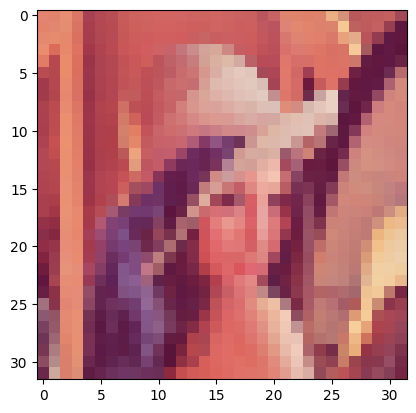

In [43]:
original_image = plt.imread(image_path)
original_image_resolution = tuple(reversed(original_image.shape[:2]))

# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])

fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")

In [44]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [45]:
def get_matrix(size=8):
    matr = []
    for i in range(size):
        matr.append(np.array(range(i * size, (i + 1) * size)))
    matr = np.array(matr)
    print(matr)

## Step 1 
### Colorspace Transformation

In [46]:
from jpeg_implementation.rgbToYuv import rgb_to_yuv

In [47]:
y, u, v = rgb_to_yuv(image=original_image)

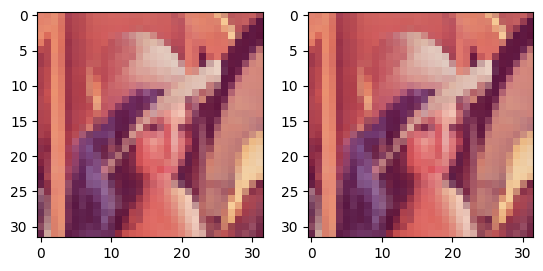

In [48]:
# def yuv_to_rgb2(y, u, v):
#     yuv = cv2.merge((y, u, v))
#     yuv = np.float32(yuv)
#     yuv /= 255
#     image = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
#     return image * 255
#
from jpeg_implementation.rgbToYuv import yuv_to_rgb

image2 = yuv_to_rgb(y,u,v)
fig, ax = plt.subplots(1,2)
ax[0].imshow(original_image)
ax[1].imshow(image2/255)

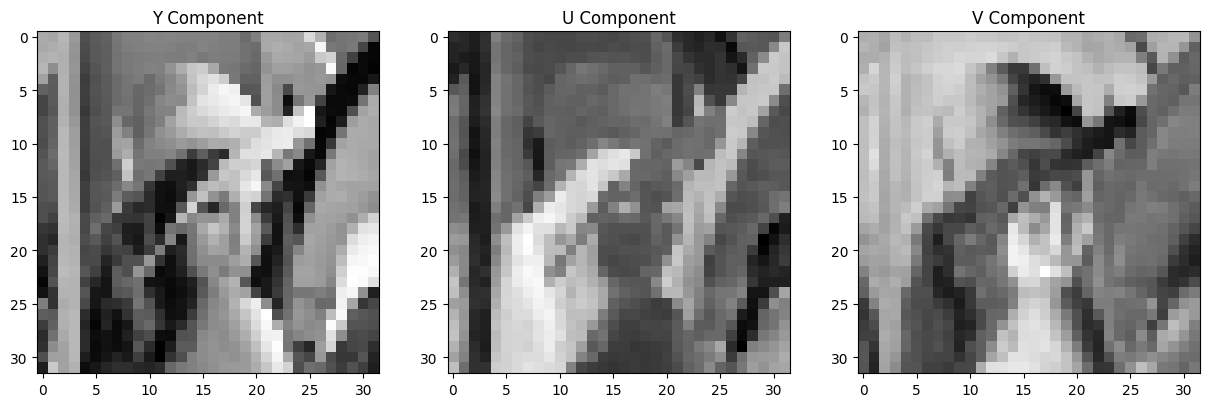

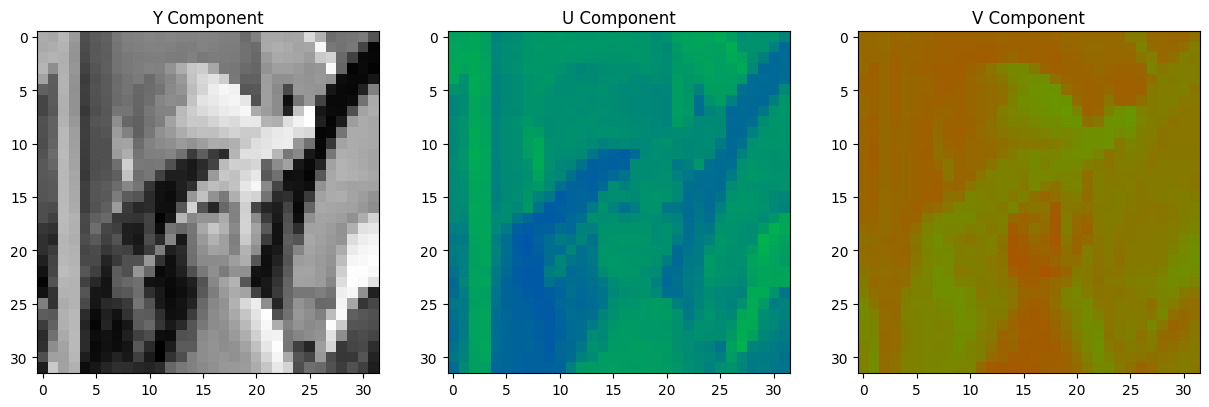

In [49]:
plot_y_u_v(y, u, v, colormap=False)
plot_y_u_v(y, u, v)


## Step 2 
### Subsampling of Color Components

In [50]:
from jpeg_implementation.subsample import subsample_u_v

In [51]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)
print(len(y), len(u_subs), len(v_subs))
print(u_subs.shape)

32 32 32
(32, 8)


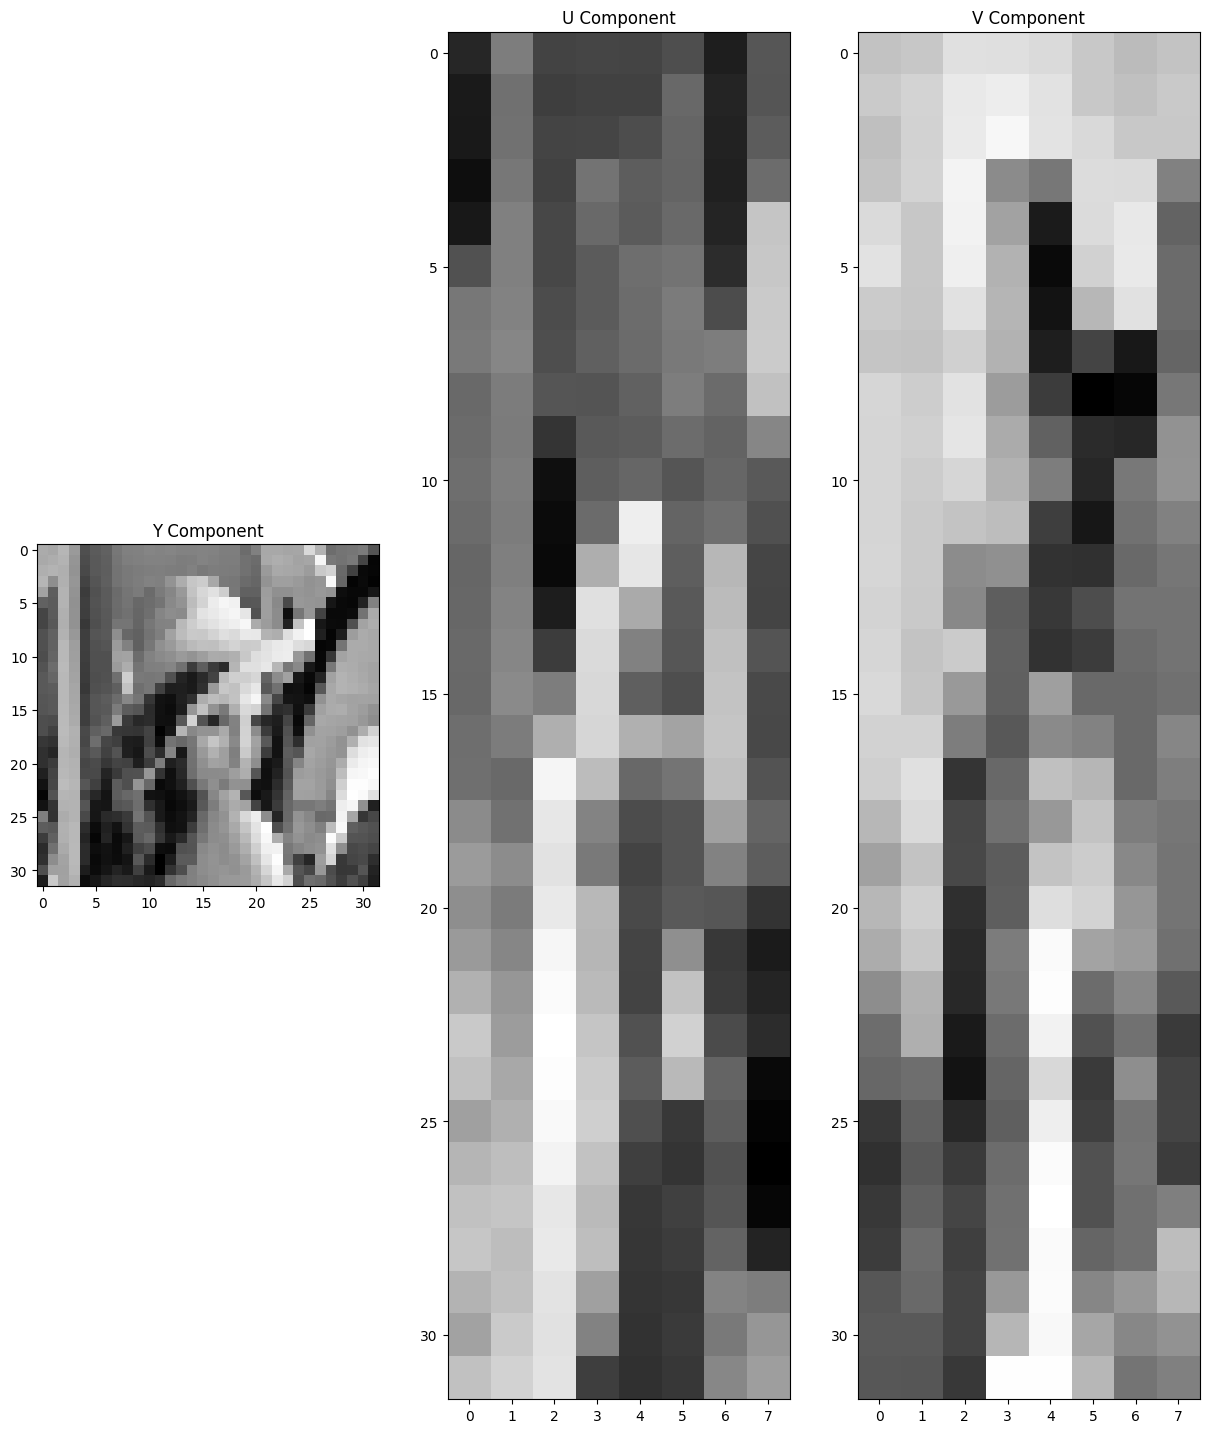

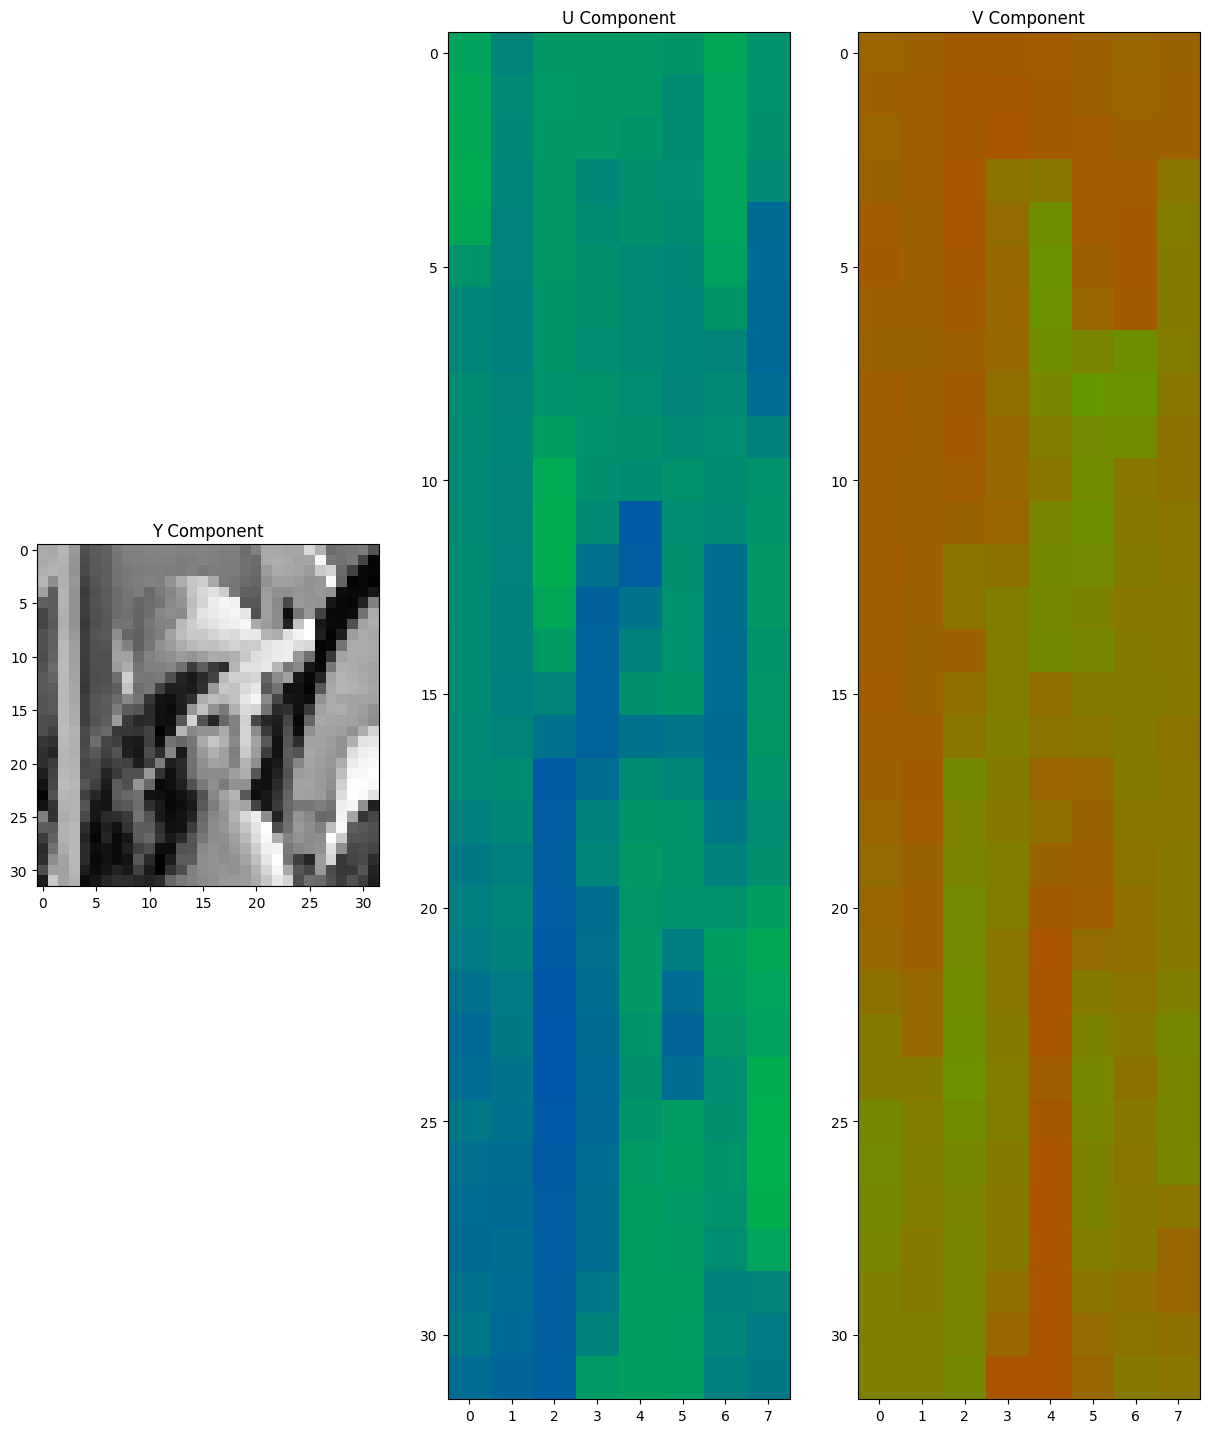

In [52]:
plot_y_u_v(y, u_subs, v_subs, colormap=False)
plot_y_u_v(y, u_subs, v_subs)


## Step 3
### Split into 8x8 Blocks

In [53]:
from jpeg_implementation.splitBlocks import split

In [54]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)

print(len(split_y), len(split_u), len(split_v))


16 4 4


[[157.94     155.598    165.419    147.076     97.664    105.64901
  109.894005 123.879   ]
 [157.082    159.18501  164.00601  143.674     95.40401  104.72
  107.976    122.477005]
 [160.658    163.316    160.8      142.457     94.105    103.72
  107.503006 120.89001 ]
 [164.501    139.251    161.099    144.528     89.746    101.43201
  108.286    121.086006]
 [151.99     106.46001  163.87102  142.24      84.778     99.69201
  105.133    115.944   ]
 [109.047005 105.090004 163.87102  141.05501   86.778     99.991005
  105.133    116.531   ]
 [ 90.735    105.019    161.55501  141.799     85.892006  99.29
  104.432    115.759   ]
 [ 91.137    103.31801  160.968    141.91301   82.707     97.589005
  103.66     122.324005]]


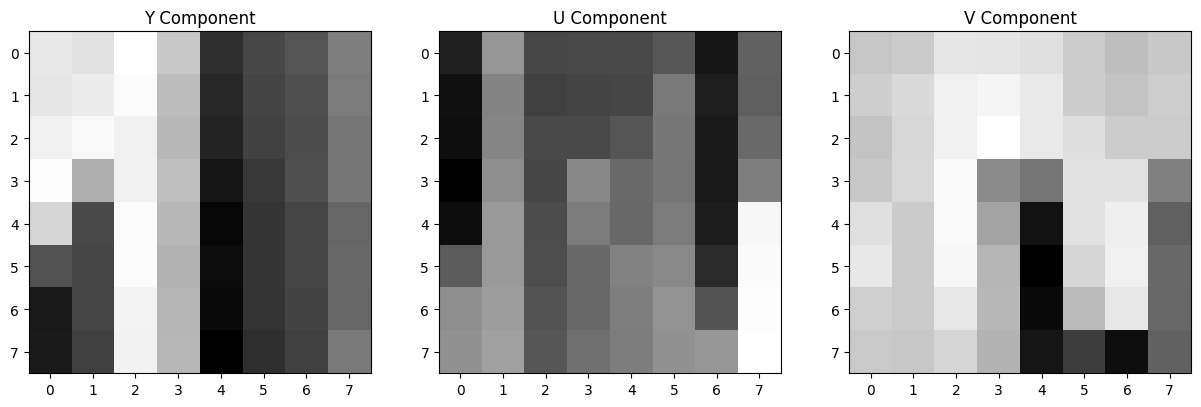

In [55]:
print(split_y[0])
plot_y_u_v(split_y[0], split_u[0], split_v[0], colormap=False)


## Step 3
### Apply dct

In [56]:
from jpeg_implementation.dct import block_dct2

In [57]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 4 
### Quantization


In [58]:
from jpeg_implementation.quantization import quantize, quantization_tables

quantization_table = quantization_tables[quantization_table_quality]

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 5
### Reordering of values, Run Length Encoding

In [59]:
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode

In [60]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)


In [61]:
print(len(rl_encoded_y), len(rl_encoded_u), len(rl_encoded_v))
print(rl_encoded_u[0])
print(rl_encoded_v[0])

328 24 36
-1.0
6.0


## Step 6
### Huffman Encoding

In [62]:
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman

data = rl_encoded_y + rl_encoded_u + rl_encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded", len(encoded), "bits")
print("encoded + table", len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8) / len(encoded))

original 3104 bits
encoded 1101 bits
encoded + table 1437 bits
compression ratio 2.819255222524977


In [63]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 888 bits
u 58 bits
v 102 bits
encoded 1048 bits
compression ratio 2.9618320610687023


## Step 7
### Serialization

In [64]:
from jpeg_implementation.serialize import store_as_file

file_size = store_as_file("test.data", huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u,
                          huff_encoded_v, quantization_table, *subsampling_settings, *original_image_resolution)
print(file_size)
print(len(data) / file_size)

447
0.8680089485458613


In [65]:
# calculate effective compression ratio
import os

original_size = os.path.getsize(image_path)
compression_ratio = original_size / file_size
print("Effective Compression Ratio:", compression_ratio, "(Compared to PNG file)")

Effective Compression Ratio: 6.5950782997762865 (Compared to PNG file)


## Step 8
### Deserialization

In [66]:
from jpeg_implementation.serialize import read_from_file

huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u, huff_encoded_v, quantization_table, j,a,b,x_dim,y_dim = read_from_file(
    "test.data")


## Step 9
### Decode Huffman

In [67]:
from jpeg_implementation.huffman import decode_huffman

rl_encoded_y = decode_huffman(huff_encoded_y, huffman_code_y)
rl_encoded_u = decode_huffman(huff_encoded_u, huffman_code_u)
rl_encoded_v = decode_huffman(huff_encoded_v, huffman_code_v)



## Step 10
### Decode run-length encoding + Reordering of values

In [68]:
from jpeg_implementation.runLengthEncode import unsort_and_run_length_decode

y_blocks = unsort_and_run_length_decode(rl_encoded_y, block_size)
u_blocks = unsort_and_run_length_decode(rl_encoded_u, block_size)
v_blocks = unsort_and_run_length_decode(rl_encoded_v, block_size)


## Step 11
### Apply inverse DCT

(16, 8, 8)
(4, 8, 8)
downsampled_resolution (8, 32)
y (32, 32)
u (32, 32)


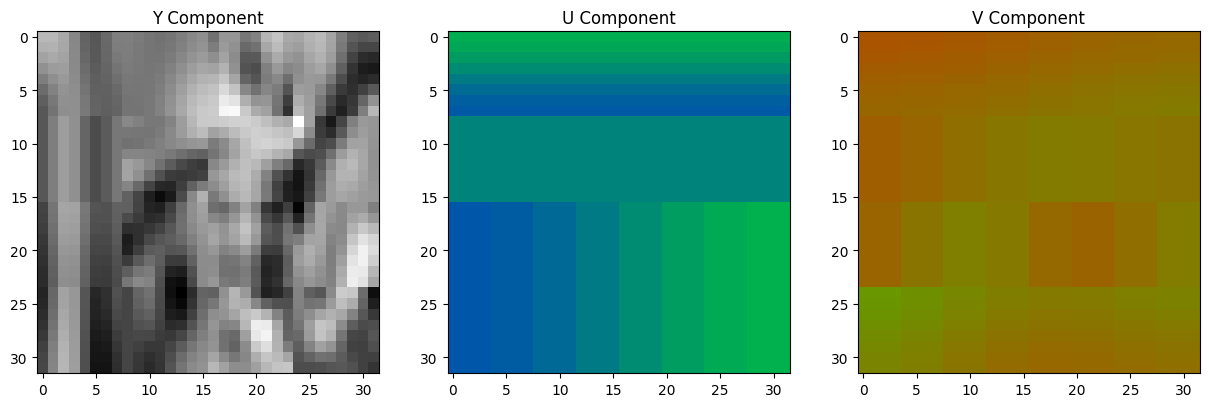

In [69]:
from jpeg_implementation.quantization import quantize_inverse
from jpeg_implementation.dct import block_idct2
from jpeg_implementation.splitBlocks import merge_blocks
from jpeg_implementation.subsample import up_sample_u_v
from jpeg_implementation.subsample import calculate_down_sampled_resolution

iq_y = quantize_inverse(y_blocks, quantization_table)
iq_u = quantize_inverse(u_blocks, quantization_table)
iq_v = quantize_inverse(v_blocks, quantization_table)

id_y = block_idct2(iq_y, block_size) + 128
id_u = block_idct2(iq_u, block_size) + 128
id_v = block_idct2(iq_v, block_size) + 128

print(id_y.shape)
print(id_u.shape)


downsampled_resolution = calculate_down_sampled_resolution(j,a,b, (x_dim, y_dim))
print("downsampled_resolution",downsampled_resolution)

compressed_y = merge_blocks(id_y, (x_dim, y_dim), block_size)
compressed_u = merge_blocks(id_u, downsampled_resolution, block_size)
compressed_v = merge_blocks(id_v, downsampled_resolution, block_size)


compressed_u, compressed_v = up_sample_u_v(compressed_u,compressed_v, j,a,b, (x_dim, y_dim))

print("y",compressed_y.shape)
print("u",compressed_u.shape)

plot_y_u_v(compressed_y,compressed_u,compressed_v)



In [70]:
print(np.max(compressed_y))
print(np.max(compressed_u))
print(np.max(compressed_v))

print(np.min(compressed_y))
print(np.min(compressed_u))
print(np.min(compressed_v))

print(np.max(y))
print(np.max(u))
print(np.max(v))

print(np.min(y))
print(np.min(u))
print(np.min(v))


236.14384471590284
128.4027988399161
207.93869777650588
24.528540894418484
107.5972011600839
139.89528369301678
213.879
145.1441
208.05069
44.963
96.305725
142.12485


-8 287


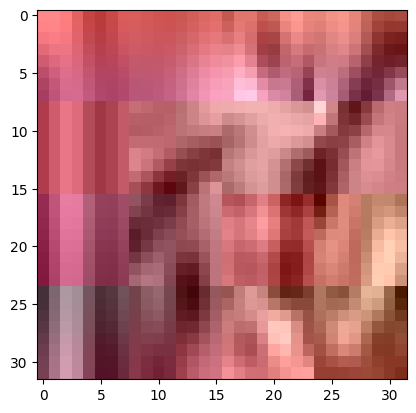

In [71]:
from jpeg_implementation.rgbToYuv import yuv_to_rgb

reconstructed_image = yuv_to_rgb(compressed_y,compressed_u, compressed_v)

print(np.min(reconstructed_image), np.max(reconstructed_image))

reconstructed_image = reconstructed_image.astype(int)
reconstructed_image = reconstructed_image.clip(0,255)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image)

# plt.axis('off')
# plt.savefig("compressed.png", bbox_inches='tight', pad_inches=0, dpi=300)

plt.imsave("compressed.png", reconstructed_image.astype(np.uint8))
plt.show()

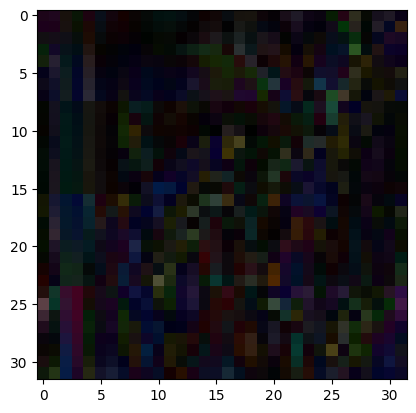

In [72]:
# res = np.dstack([reconstructed_image, np.zeros(512**2).reshape(512,512)])
original_image_rescaled = original_image * 255
original_image_rescaled = original_image_rescaled.astype(int)
diff = np.abs(original_image_rescaled - reconstructed_image)

# print("original_image",np.min(original_image_rescaled), np.max(original_image_rescaled))
# print("reconstructed_image",np.min(reconstructed_image), np.max(reconstructed_image))
#
# white = np.zeros(512**2*3).reshape((512,512,3)) + 254
#
# # diff2 = 255 - diff
# print("diff", np.min(diff), np.max(diff))
# # print("diff2", np.min(diff2), np.max(diff2))

fig, ax = plt.subplots()
ax.imshow(diff)
plt.show()


diff2 0 254


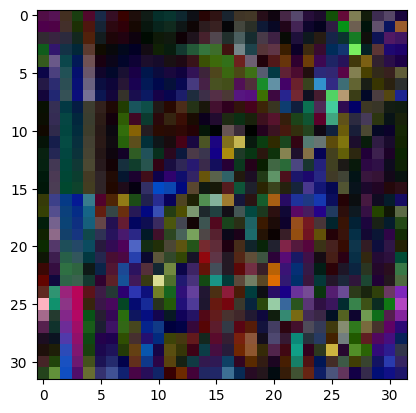

In [73]:
# extrapolate differences for better visualisation
diff2 = diff * (255/np.max(diff))
# diff2 = (diff2* -1) + 255

diff2 = diff2.astype(int)
print("diff2", np.min(diff2), np.max(diff2))

fig, ax = plt.subplots()
ax.imshow(diff2)
plt.show()


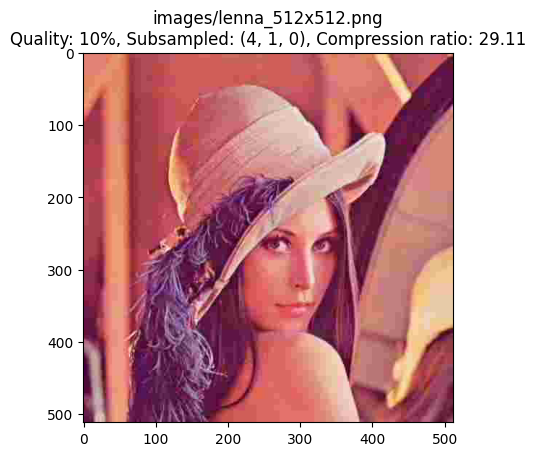

images/lenna_512x512.png (4, 1, 0) 10 1.9597563743591309 seconds


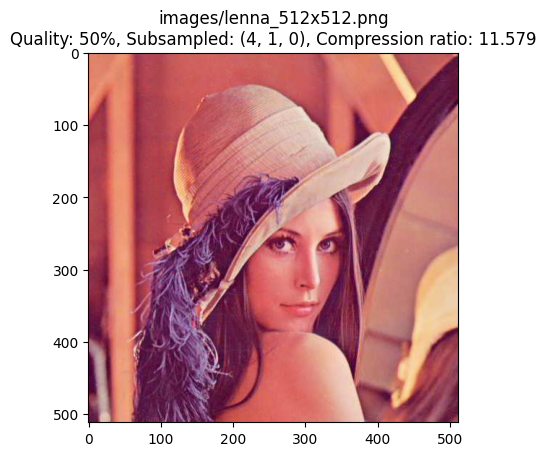

images/lenna_512x512.png (4, 1, 0) 50 1.7044579982757568 seconds


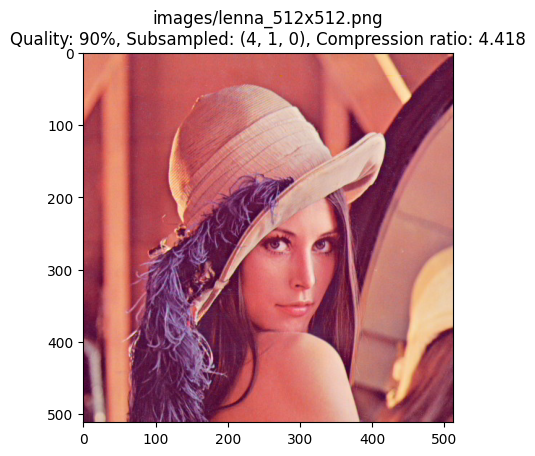

images/lenna_512x512.png (4, 1, 0) 90 1.9128670692443848 seconds


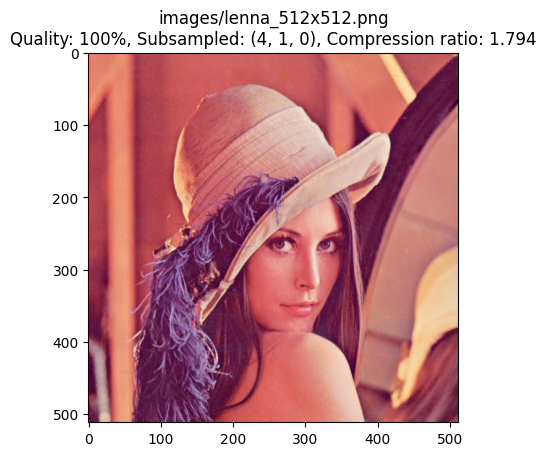

images/lenna_512x512.png (4, 1, 0) 100 2.408454656600952 seconds


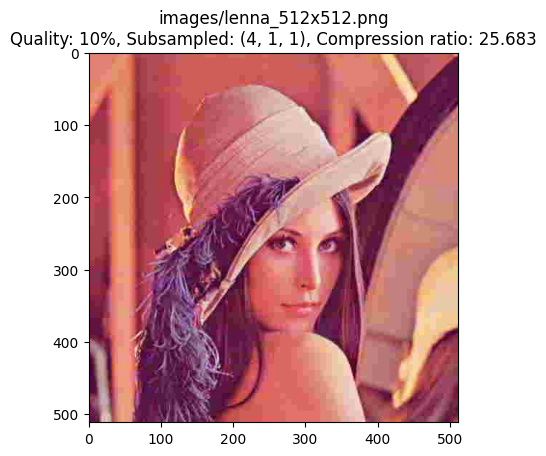

images/lenna_512x512.png (4, 1, 1) 10 1.9338257312774658 seconds


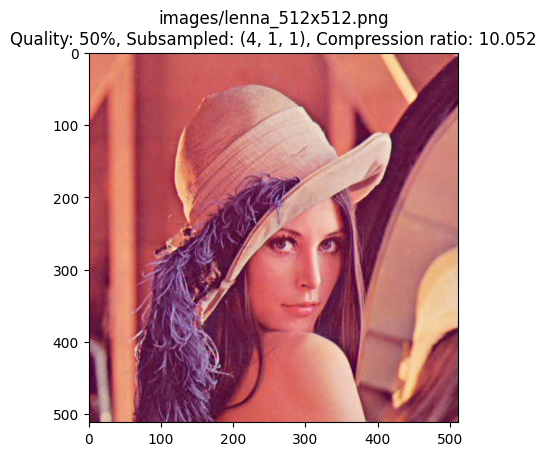

images/lenna_512x512.png (4, 1, 1) 50 1.981698989868164 seconds


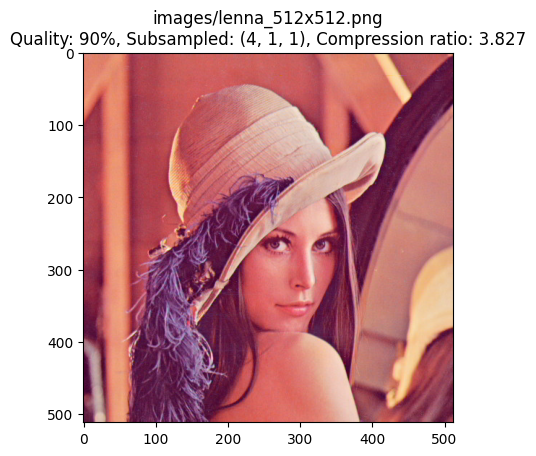

images/lenna_512x512.png (4, 1, 1) 90 2.2320470809936523 seconds


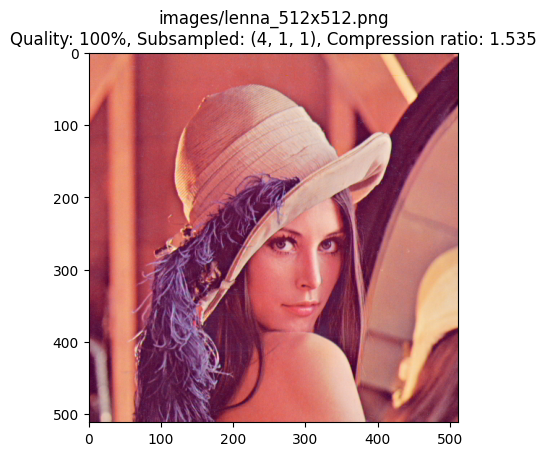

images/lenna_512x512.png (4, 1, 1) 100 2.8314085006713867 seconds


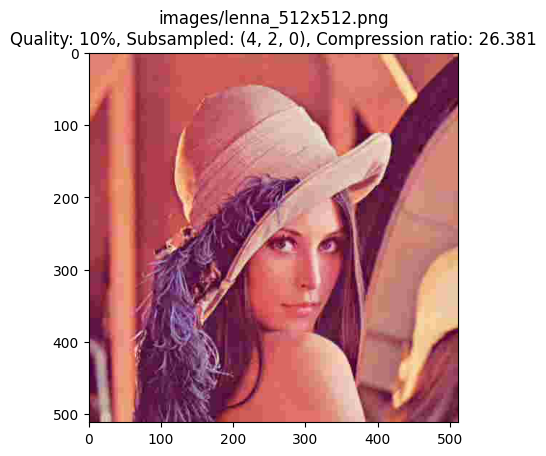

images/lenna_512x512.png (4, 2, 0) 10 1.8460779190063477 seconds


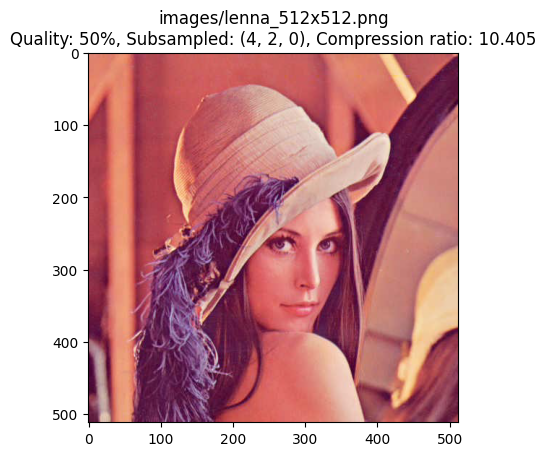

images/lenna_512x512.png (4, 2, 0) 50 1.975724458694458 seconds


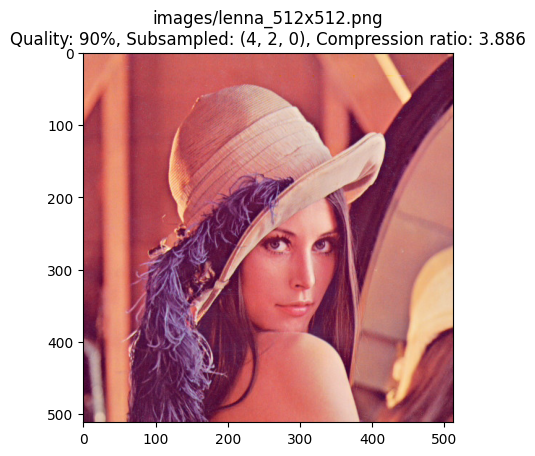

images/lenna_512x512.png (4, 2, 0) 90 2.2130699157714844 seconds


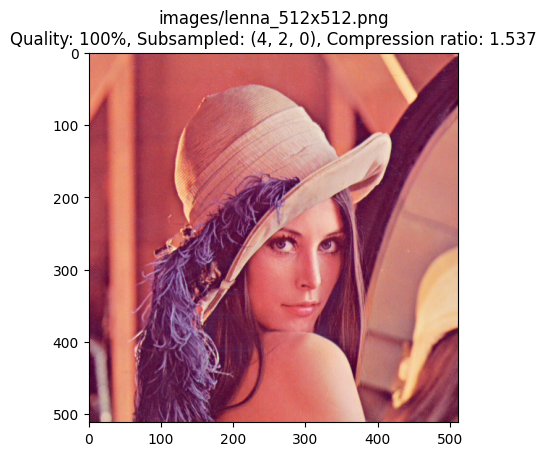

images/lenna_512x512.png (4, 2, 0) 100 2.65988826751709 seconds


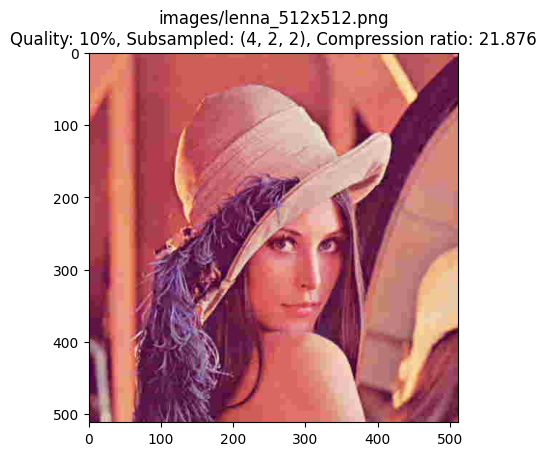

images/lenna_512x512.png (4, 2, 2) 10 2.3257758617401123 seconds


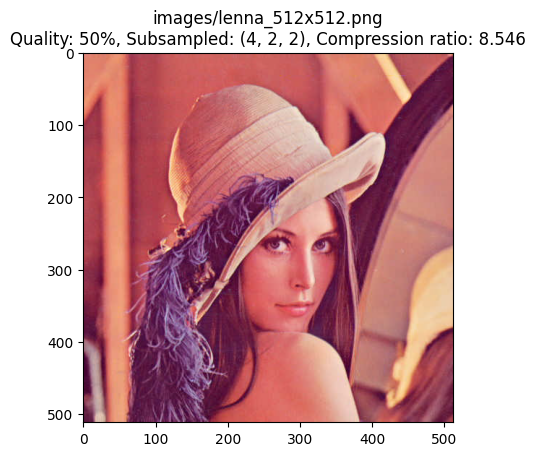

images/lenna_512x512.png (4, 2, 2) 50 2.4634180068969727 seconds


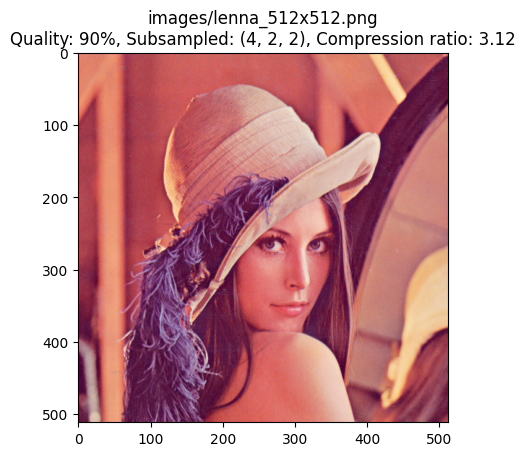

images/lenna_512x512.png (4, 2, 2) 90 2.734624147415161 seconds


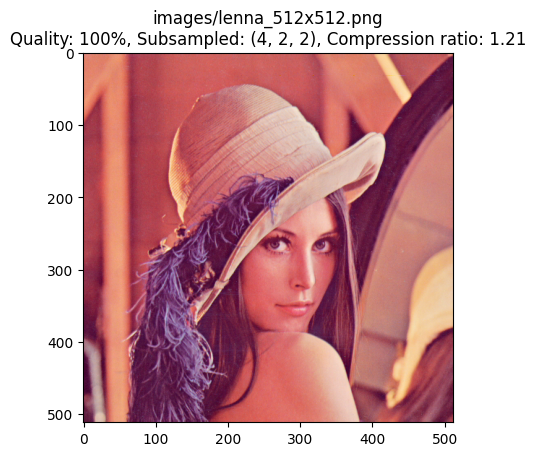

images/lenna_512x512.png (4, 2, 2) 100 3.4836807250976562 seconds


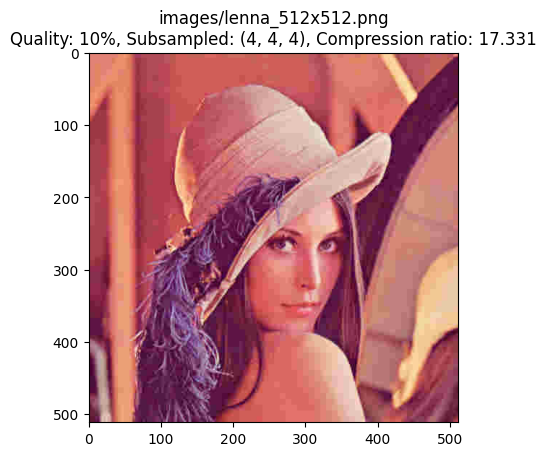

images/lenna_512x512.png (4, 4, 4) 10 3.8048453330993652 seconds


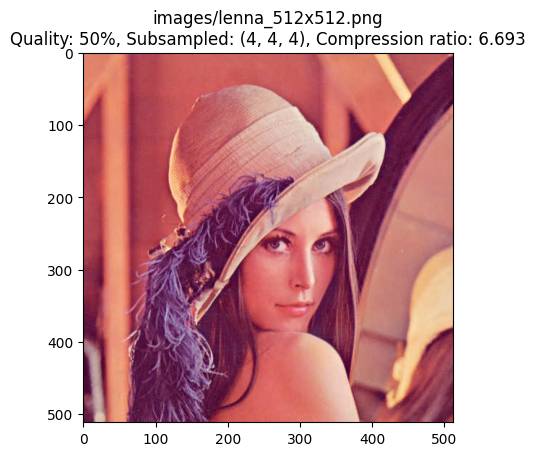

images/lenna_512x512.png (4, 4, 4) 50 3.8217687606811523 seconds


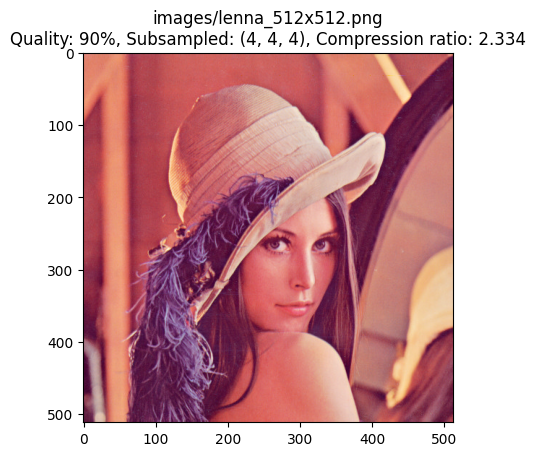

images/lenna_512x512.png (4, 4, 4) 90 4.065232753753662 seconds


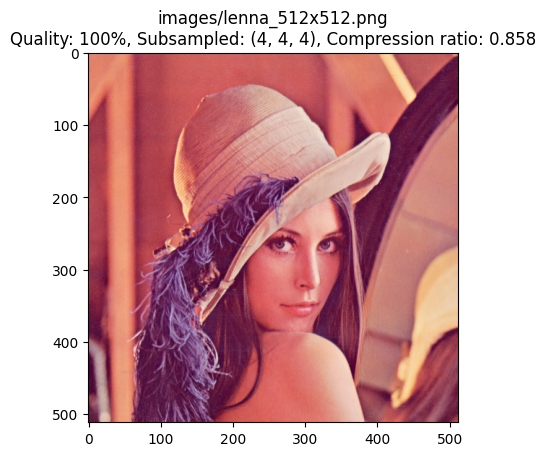

images/lenna_512x512.png (4, 4, 4) 100 5.248432636260986 seconds
finished


In [2]:
from jpeg_implementation.EasyJpeg import EasyJpeg
import time

subsampling_settings_list = [(4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)]
qualities = [10,50,90,100]

images = [
    # "images/Barns_grand_tetons_1600x1195.png",
    # "images/christmas_tree_6000x4000.png",
    # "images/christmas_tree_600x400.png",
    # "images/christmas_tree_194x129.png",
    "images/lenna_512x512.png",
    # "images/lenna_256x256.png",
    # "images/lenna_128x128.png",
    # "images/lenna_64x64.png",
    # "images/lenna_32x32.png",
]

for img in images:
    for s in subsampling_settings_list:
        for q in qualities:
            t0 = time.time()
            jpeg = EasyJpeg.from_png(img, q, s, 8)
            compression_ratio = jpeg.get_compression_ratio()
            jpeg.show_decompressed(f"{img}\nQuality: {str(q)}%, Subsampled: {str(s)}, Compression ratio: {round(compression_ratio,3)}")
            t1 = time.time()
            print(img, s, q, t1-t0, "seconds")

print("finished")

In [12]:
subsampling_settings_list = [(4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)]
qualities = [10,50,90,100]

images = [
    "images/Barns_grand_tetons_1600x1195.png",
    "images/christmas_tree_6000x4000.png",
    "images/christmas_tree_600x400.png",
    "images/christmas_tree_194x129.png",
    "images/lenna_512x512.png",
    "images/lenna_256x256.png",
    "images/lenna_128x128.png",
    "images/lenna_64x64.png",
    "images/lenna_32x32.png",
]

for img in reversed(images):
    for s in subsampling_settings_list:
        for q in qualities:
            t0 = time.time()
            jpeg = EasyJpeg.from_png(img, q, s, 8)
            compression_ratio = jpeg.get_compression_ratio()
            t1 = time.time()
            compression_time = t1-t0
            file_name = img.split("/")[-1].split(".")[0]
            out_file_name = f"compressed_images/{file_name}_{str(q)}_{str(s)}_{round(compression_ratio,3)}_{round(compression_time,4)}"
            jpeg.store_compressed(f"{out_file_name}.binary")
            jpeg.store_compressed_png(f"{out_file_name}.png")
            print(img, s, q, compression_time, "seconds", out_file_name)
        #     break
        # break
    # break
print("finished")

images/lenna_32x32.png (4, 1, 0) 10 0.007978439331054688 seconds compressed_images/lenna_32x32_10_(4, 1, 0)_7.444_0.008
images/lenna_32x32.png (4, 1, 0) 50 0.008974790573120117 seconds compressed_images/lenna_32x32_50_(4, 1, 0)_3.201_0.009
images/lenna_32x32.png (4, 1, 0) 90 0.010970354080200195 seconds compressed_images/lenna_32x32_90_(4, 1, 0)_1.607_0.011
images/lenna_32x32.png (4, 1, 0) 100 0.013962507247924805 seconds compressed_images/lenna_32x32_100_(4, 1, 0)_0.883_0.014
images/lenna_32x32.png (4, 1, 1) 10 0.008975744247436523 seconds compressed_images/lenna_32x32_10_(4, 1, 1)_6.595_0.009
images/lenna_32x32.png (4, 1, 1) 50 0.009973287582397461 seconds compressed_images/lenna_32x32_50_(4, 1, 1)_2.879_0.01
images/lenna_32x32.png (4, 1, 1) 90 0.010970354080200195 seconds compressed_images/lenna_32x32_90_(4, 1, 1)_1.445_0.011
images/lenna_32x32.png (4, 1, 1) 100 0.014960050582885742 seconds compressed_images/lenna_32x32_100_(4, 1, 1)_0.792_0.015
images/lenna_32x32.png (4, 2, 0) 10 0

In [ ]:
# todo peak signal to noise ratio